In [107]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import re
import collections
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer # Tokenizer in NLTK that is meant for tweets. We will be implementing.
from nltk.corpus import stopwords

In [67]:
# Data splits

train_data = pd.read_csv('data/nlp-getting-started/train.csv')
test_      = pd.read_csv('data/nlp-getting-started/test.csv')

div        = int(len(test_)/2)
test_data  = test_[div:]
dev_data   = test_[:div]

In [148]:
test_data.head()

,id,keyword,location,text
1631,5500,flames,"Fargo, ND",You were just waiting for us to go down in flames
1632,5504,flames,NaN,This is gonna go down in flames ?? https://t.c...
1633,5508,flames,"Here, There & Everywhere..",I'm listening to 'Zion' by Flames on #Pandora ...
1634,5511,flattened,NaN,I think that's been the best bit of this match...
1635,5512,flattened,support all girls!,why would anyone want to hear some type of shi...


In [45]:
dat.head() # 0 for no disaster 1 for disaster

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [130]:
num_disaster = len(dat[dat['target']==1])
num_nodisaster = len(dat[dat['target']==0])
num_disaster_kw =  len(dat[(dat.target == 1) & (~dat.keyword.isnull())])
num_nd_kw =  len(dat[(dat.target == 0) & (~dat.keyword.isnull())])
print('disaster tweets: ',num_disaster, '\nnot disaster tweets: ',num_nodisaster
      ,'\ndisaster tweets w/ kw: ', num_disaster_kw, '\nnot disaster tweets w/ kw: ', num_nd_kw)

disaster tweets:  3271 
not disaster tweets:  4342 
disaster tweets w/ kw:  3229 
not disaster tweets w/ kw:  4323


In [143]:
# helpers 
def sort(d,r):
    return sorted(d.items(),key=lambda item:item[1],reverse=r)

Text(0, 0.5, 'Counts')

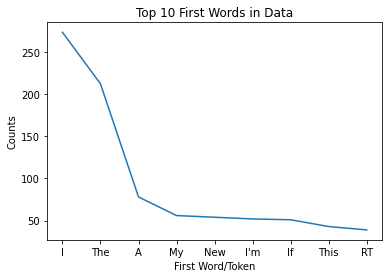

In [144]:
first_word = train_data.text.str.split(expand=True)[0]
first_words_c = dict(collections.Counter(first_word))
sorted_fw = sort(first_words_c,True)

x, y = zip(*sorted_fw[0:9]) # * to unpack tuple, zip to split 
plt.plot(x,y)
plt.title('Top 10 First Words in Data')
plt.xlabel('First Word/Token')
plt.ylabel('Counts')

In [64]:
# remove the RT in tweets, as this is commonly used as 'retweet' by twitter users
dat[dat.text.str.contains('RT')]

,id,keyword,location,text,target
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
56,80,ablaze,South Africa,TRUCK ABLAZE : R21. VOORTREKKER AVE. OUTSIDE O...,1
75,109,accident,NaN,RT @SleepJunkies: Sleeping pills double your r...,0
86,128,accident,"New Hanover County, NC",FYI CAD:FYI: ;ACCIDENT PROPERTY DAMAGE;NHS;999...,1
87,129,accident,Maldives,RT nAAYf: First accident in years. Turning ont...,1
...,...,...,...,...,...
7442,10650,wounds,Earth,RT @DianneG: Gunshot wound #9 is in the bicep....,0
7475,10692,wreck,"Lebanon, Tennessee",Watertown Gazette owner charged in wreck http:...,1
7510,10743,wreckage,WorldWide,#Australia #News ; RT janeenorman: 'High proba...,1
7518,10751,wreckage,Bangkok,CIA plot! *rolling eyes* RT @ajabrown: Chinese...,1


In [156]:
dat[dat.keyword.dropna(inplace='n').str.contains('body%20bags')]

ValueError: For argument "inplace" expected type bool, received type str.

In [65]:
# We would also remove # hashtags from the tweets texts, maybe even consider @
dat[dat.text.str.contains('#')]

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
...,...,...,...,...,...
7598,10853,NaN,NaN,Father-of-three Lost Control of Car After Over...,1
7599,10854,NaN,NaN,1.3 #Earthquake in 9Km Ssw Of Anza California ...,1
7601,10859,NaN,NaN,#breaking #LA Refugio oil spill may have been ...,1
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1


In [62]:
# Should remove all feature sets that begin with HTTP, since they are links to other sites, causes noise
dat[dat.text.str.contains('http')]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
37,55,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1
...,...,...,...,...,...
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7607,10867,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [47]:
# skip this shit for now

stemmer = PorterStemmer().stem
tokenize = nltk.word_tokenize

def stem(tokens,stemmer = PorterStemmer().stem):
    return [stemmer(w.lower()) for w in tokens] 

def lemmatize(text):
    """
    Extract simple lemmas based on tokenization and stemming
    Input: string
    Output: list of strings (lemmata)
    """
    return stem(tokenize(text))



# reference
https://necromuralist.github.io/Neurotic-Networking/posts/nlp/01-twitter-preprocessing-with-nltk/